# Imports

In [1]:
import os
import sys

# Adds project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Adds include folder to find dependencies.py
sys.path.append(os.path.join(project_root, "include"))

import dependencies

from dependencies import *


# Getting Data Locally (update to support collab or other more shareable/cloud based service)

In [2]:

save_outputs_to = r"C:\Users\miles\favela_analysis\output\rocinha"
site_to_study = r"C:\Users\miles\favela_project\test_rocinha.shp"
site_name = "rocinha"


In [3]:
# "C:\Users\miles\OneDrive\Desktop\school\UROP\Data\best_test_set.shp"

try:
    buildings_path = site_to_study #DATA SOURCE GOES HERE
    clean_buildings, tessellation, excluded_buildings, report = perform_perfect_tessellation(
        buildings_path,
        min_area=1.0,
        buffer_dist=100,
        max_iterations=10
    )

    print_perfect_tessellation_report(report)

except Exception as e:
    print(f"Error: {str(e)}")



Tessellation Report:
--------------------------------------------------
Original building count: 36132
Excluded building count: 84
Final building count: 36048
Tessellation cell count: 36048

Reasons for exclusion:
  - too_small: 2 buildings
  - tessellation_failure: 82 buildings


In [4]:
output_dir = r"C:\Users\miles\favela_analysis\output"

# Initialize calculator and run calculations
calculator = BuildingMetricsCalculator(clean_buildings, tessellation, output_dir) #BuildingMetricsCalculator Class
calculator.run_all_calculations()


c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_distribution.py:285: UserWarning: The indices of the two GeoSeries are different.
  (geoms.distance(geometry.geometry, align=True)).groupby(level=0).mean()


# Spatial Joint MM and TP

In [5]:
clean_buildings = clean_buildings.join(tessellation, rsuffix='_tessellation')
clean_buildings = clean_buildings.set_geometry("geometry")


# GROUND TRUTH DATA


=== Favela Classification Analysis ===
Total buildings: 36048
Favela buildings: 20229 (56.1%)
Non-favela buildings: 15819

Building type distribution:
1.0: 20229 buildings


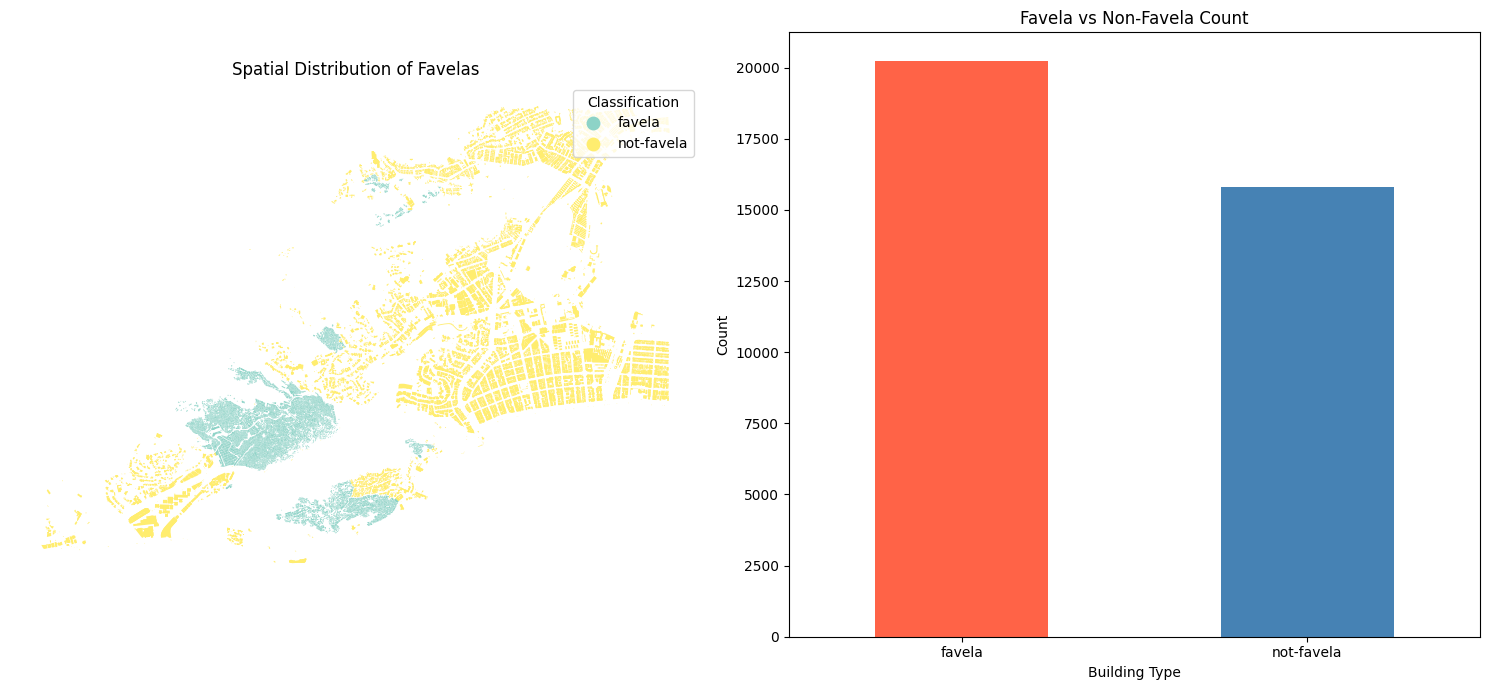

0        0.209513
1        0.636289
2        0.630147
3        0.626854
4        0.505517
           ...   
36043    0.572737
36044    0.586076
36045    0.555552
36046    0.579233
36047    0.589045
Name: circular_com, Length: 36048, dtype: float64


In [6]:
# from ground_truth import classify_and_analyze_favelas

try:
    classified_buildings, analysis = classify_and_analyze_favelas(
        clean_buildings,
        type_column='nome_count'
    )

    ground_truth_gdf = classified_buildings

    # merge buildings
    clean_buildings['label'] = classified_buildings['label']

    plt.show()

except Exception as e:
    print(f"Error during classification analysis: {str(e)}")
print(classified_buildings['circular_com'])


# XG Boost Classification

In [7]:
results = run_xgboost(ground_truth_gdf)

# save results
save_xgboost_results(results, save_outputs_to, site_name)

ground_truth_gdf = results['updated_gdf']
metrics = results['metrics']
xgb_model = results['model']
X_imputed = results['X_imputed']
X = results['X']
X_train = results['X_train']

print(results['classification_report'])


Target value counts:
1    20229
0    15819
Name: count, dtype: int64
Accuracy: 97.75312066574202
Classification Report:
{'favela': {'precision': 0.9757556675062973, 'recall': 0.9733040201005025, 'f1-score': 0.9745283018867924, 'support': 3184.0}, 'not-favela': {'precision': 0.9789291026276649, 'recall': 0.9808743169398907, 'f1-score': 0.9799007444168735, 'support': 4026.0}, 'accuracy': 0.9775312066574202, 'macro avg': {'precision': 0.9773423850669811, 'recall': 0.9770891685201966, 'f1-score': 0.977214523151833, 'support': 7210.0}, 'weighted avg': {'precision': 0.9775276855088805, 'recall': 0.9775312066574202, 'f1-score': 0.9775282261067794, 'support': 7210.0}}
Feature Importances:
                        Feature  Importance
5                     adjacency    0.394427
4   mean_interbuilding_distance    0.286321
2                           lal    0.050740
0                          area    0.033851
22                 shared_walls    0.025844
21                     tes_area    0.024348
11

In [8]:
shap_results = calculate_shap_results(xgb_model, X_imputed, metrics, ground_truth_gdf)

save_shap_results(shap_results, output_dir, site_name)


100%|===================| 35981/36048 [02:18<00:00]        c:\Users\miles\favela_analysis\src\shap_calculator.py:78: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  updated_gdf.to_file(shapefile_path)


SHAP results successfully saved to: C:\Users\miles\favela_analysis\output
